# Extract Cluster Distances of Snow Grain Types

**What are we doing here?**
We are trying to retrieve the distance between the clusters of grain types. To this end we can project the features of the grain types into a lower dimensional space, e.g. 3 dim, and calculate the distance between the clusters in that space. Alternatively, we could also calculate the vector distance (i.e. using all features, in the full dimensional space). However, the data here can be reduced to fewer dimensions (as PCA has shown in snowdragon (explained variance)), which is computationally more effective and can be grasped more intuitively.

**Why using t-SNE and not PCA?**

T-SNE preserves the local structure of data rather than the global structure, i.e. clusters. While PCA preserves the variance of the data, t-SNE preserves distance. t-SNE is also a good choice for our dataset, since it's a non-linear dim reduction method, i.e. it's suitable for non-lineraly separable datasets. It's non-deterministic, which is why we need to run it several times and average the results (PCA is deterministic). It's not sensitive to outliers or the odering of datapoints (which is what we want here). The biggest drawback of t-SNE is that it is computationally expensive and depends on hyperparameters (e.g. perplexity).

**t-SNE explanation** (extracted from Kaggle):
t-SNE is a non-linear, unsupervised technique primarily used for data exploration and visualization of high-dimensional data. It provides you an intuition of how the data is arranged in a high-dimensional space. The t-SNE algorithm calculates a similarity measure between points in high dimensional space using Gaussian distribution then in the low dimensional space using Cauchy distribution. Finally it measures the probability distribution of the two dimensional spaces by Kullback-Liebler divergence and optimize the KL cost function using gradient descent.

**Wait, but why are you not using Clustering methods?**

Clustering makes sense when we do not know the clusters yet - but we already have labels for our clusters. We only want to retrieve distance metrics from the clusters we already have. Supervised clustering could help here too (future work), however, they are often used to build a taxonomy, e.g. a hierarchical taxonomy of all the data available. This is also not exactly what we want. 

Hence, we are trying to project the features we have in a lower-dimensional space, and calculate the cluster distance in that space.

*Just as a note*: 
More advanced unsupervised clustering methods that can handle non-flat geometry:

- [DBSCAN](https://scikit-learn.org/stable/modules/clustering#dbscan)
- [OPTICS](https://scikit-learn.org/stable/modules/clustering#optics) 
- [HDBSCAN](https://scikit-learn.org/stable/modules/clustering#hdbscan)


In [162]:
# import stuff you need 
from snowdragon import ROOT_DIR, DATA_DIR, OUTPUT_DIR
from snowdragon.utils.helper_funcs import load_smp_data, load_configs

%matplotlib notebook
%matplotlib inline

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.manifold import TSNE
from scipy.spatial import distance

In [16]:
# data paths 
smp_normalized_npz = DATA_DIR / "tsne_project" / "tsne_smp_profiles_normalized.npz"
output_dir = OUTPUT_DIR / "tsne_project"

In [17]:
# configs
graintype_configs = load_configs(
    config_subdir="graintypes",
    config_name="graintypes.yaml",
) 
color_configs = load_configs(
    config_subdir="colors",
    config_name="colors.yaml",
) 

In [129]:
# t-sne configs
n_components = 3 # number of dimensions 
verbose = 1
perplexity = 40 
n_iter = 300 

# cluster distance configs
metric = "euclidean"

In [5]:
# experiment configs
num_runs = 10

random_tokens = [
    42,
    4973,
    97245,
    3039,
    7,
    38944,
    23574,
    65839,
    235,
    8745,
]

if len(random_tokens) != num_runs:
    raise ValueError("You need as many random tokens as number of runs.")

## Load SMP Data, Labels and Colors

In [6]:
# load data
raw_data = load_smp_data(smp_normalized_npz)
labelled_data = raw_data[(raw_data["label"] != 0) & (raw_data["label"] != 2)]
x = labelled_data.drop(["label", "smp_idx"], axis=1)
y = labelled_data["label"]

data = {
    "x": x,
    "y": y,
}

In [165]:
# retrieve labels and colors 
label_order = [3.0, 4.0, 5.0, 6.0, 12.0, 16.0, 17.0]
anti_labels = graintype_configs["anti_labels"]
anti_labels_long = graintype_configs["anti_labels_long"]
colors = color_configs["grains"]
anti_colors = {anti_labels_long[key] : value for key, value in colors.items() if key in labelled_data["label"].unique()}

## t-SNE

In [8]:
def run_tsne(
    data: dict,
    n_components: int, 
    verbose: int,
    perplexity: int,  
    n_iter: int,
    random_state: int,
) -> pd.DataFrame:
    """ Runs t-SNE on data for given parameters and a random seed
    """ 
    if n_components > 3:
        # slower, but barned hut only works for n_components < 4
        method = "exact"
    else:
        method = "barnes_hut"
    tsne = TSNE(
        n_components = n_components, 
        verbose = verbose, 
        perplexity = perplexity,
        n_iter = n_iter,
        random_state = random_state,
        method = method,
    )
    tsne_results = tsne.fit_transform(data["x"])

    # create dictionary for pd.DataFrame 
    tsne_dict = {"t-SNE {}".format(n+1): tsne_results[:, n] for n in range(n_components)}
    tsne_dict["label"] = data["y"]
    
    return pd.DataFrame(tsne_dict)

## Visualize t-SNE

In [24]:
def visualize_tsne(
        tsne_results: pd.DataFrame,
        colors: dict, 
        anti_colors: dict, 
        ): 
    """ 
    """
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(projection="3d")
    color_labels = [colors[label] for label in tsne_results["label"]]
    ax.scatter(xs=tsne_results["t-SNE 1"], ys=tsne_results["t-SNE 2"], zs=tsne_results["t-SNE 3"], c=color_labels, alpha=0.3)
    ax.set_xlabel("tsne-one")
    ax.set_ylabel("tsne-two")
    ax.set_zlabel("tsne-three")
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', alpha=0.5) for color in anti_colors.values()]
    plt.legend(markers, anti_colors.keys(), title="Snow Grain Types", numpoints=1, loc="center left", bbox_to_anchor=(1.04, 0.5)) #loc="upper right"#,
    # get rid off ticks and set a marker for zero
    plt.xticks([])
    plt.yticks([])
    plt.axhline(0, color="gray", linewidth=1.5, linestyle=':')
    plt.axvline(0, color="gray", linewidth=1.5, linestyle=':')
    plt.tight_layout()
    plt.title("t-SNE on all Labelled SMP Profiles (3-dim)")
    plt.show()

## Retrieve Cluster Distances t-SNE
Based on PCA results from snowdragon, we decide that we can explain most of the data variance in a 3-dim space. Furthermore, t-SNE runs very effectively with the Barnes-Hut method that only supports up to 3 dimensions. Run-time is getting very large for the alternative "exact" method, and the kernel is crashing (for some reason).

Thus, we focus on 3-dim reduction. It's okay that the data is partially overlapping (that's just the nature of the data) and perfectly separable.

In [160]:
# get centroids of clusters 
def get_centroids(
    tsne_results: pd.DataFrame,
) -> pd.DataFrame:
    """ Returns a pandas Dataframe that contains the centroids for each label 
    """
    return tsne_results.groupby(["label"]).mean()
    
#print(mean_coords.loc[3.0, :])

# calculate distance between different labels (return distance matrix)
def get_distances(
    centroids: pd.DataFrame,
    label_order: list = [3.0, 4.0, 5.0, 6.0, 12.0, 16.0, 17.0],
    metric: str = "euclidean",
) -> np.array:
    """ Returns a distance matrix for all labels 
    """
    # reorder the centroids
    centroids = centroids.reindex(label_order)
    # get the distanc matrix 
    dist_matrix = distance.cdist(centroids, centroids, metric)

    return dist_matrix

# make sure that the distances are between 0 and 1
def get_normalized_distances(
    tsne_results: pd.DataFrame,
    distances: np.array,
    metric: str,
    max_dist: float = None,
) -> np.array:
    """ Retrieves the maximum possible distance between two data points,
    and normalizes the distances between 0 and 1. 
    """
    all_points = np.array(tsne_results.drop(["label"], axis=1))

    all_distances = distance.cdist(all_points, all_points, metric)
    if max_dist is None:
        max_dist = np.max(all_distances)
        print("Maximum recorded distance between two data points: {}".format(max_dist))
    min_dist = np.min(all_distances)
    normalized_distances = (distances - min_dist) / (max_dist - min_dist)
    return normalized_distances

# transform the distance matrix into a similarity matrix
def get_similarities(
    distances: np.array,
) -> np.array: 
    """ Converts the distance matrix to a similarity distance matrix
    """
    return 1 - distances


In [ ]:
# summarize all the code into one function

## Visualize Grain Type Distances 

In [229]:
# plot heatmap for similarity / distance matrix
def plot_matrix(
    matrix: np.array, 
    label_order: list = [3.0, 4.0, 5.0, 6.0, 12.0, 16.0, 17.0],
    file_name: str = None,  
    title: str = "Distance Matrix",
):
    """ Plots the distance or similarity matrix 
    """
    sns.heatmap(
        matrix, 
        annot=True, 
        fmt=".2f", 
        #vmin=0, vmax=1,
        center=0, 
        #cmap= "YlGnBu",#"Blues", #"YlGnBu",
        annot_kws={"fontsize": 8},
        cbar_kws={"label": "Normalized Euclidean Distance"},
    )
    #plt.tight_layout(rect=[-0.02, 0, 1.07, 0.95])
    labels = [anti_labels[label] for label in label_order]
    plt.xticks(
        np.arange(0, 7) + 0.5,
        labels,
        fontsize=10, 
        rotation=45,
    )
    plt.yticks(
        np.arange(0, 7) + 0.5,
        labels,
        fontsize=10,
        rotation=0,
    )
    plt.title(title)
    if file_name is not None:
        plt.savefig(file_name, dpi=200)
        plt.close()
    else:
        plt.show()

In [ ]:
# visualize centroids in 3d space
# with right colors 
# connections more or less intense depending on distance matrix


## Run t-SNE: Show Example

In [11]:
# run a single time
tsne_results = run_tsne(
    data = data,
    n_components = n_components, 
    verbose = verbose,
    perplexity = perplexity,  
    n_iter = n_iter,
    random_state = random_tokens[0],
)

/home/julia/Software/anaconda3/envs/snowdragon_test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30894 samples in 0.002s...
[t-SNE] Computed neighbors for 30894 samples in 1.581s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30894
[t-SNE] Computed conditional probabilities for sample 2000 / 30894
[t-SNE] Computed conditional probabilities for sample 3000 / 30894
[t-SNE] Computed conditional probabilities for sample 4000 / 30894
[t-SNE] Computed conditional probabilities for sample 5000 / 30894
[t-SNE] Computed conditional probabilities for sample 6000 / 30894
[t-SNE] Computed conditional probabilities for sample 7000 / 30894
[t-SNE] Computed conditional probabilities for sample 8000 / 30894
[t-SNE] Computed conditional probabilities for sample 9000 / 30894
[t-SNE] Computed conditional probabilities for sample 10000 / 30894
[t-SNE] Computed conditional probabilities for sample 11000 / 30894
[t-SNE] Computed conditional probabilities for sample 12000 / 30894
[t-SNE] Computed conditional probabilities for sa

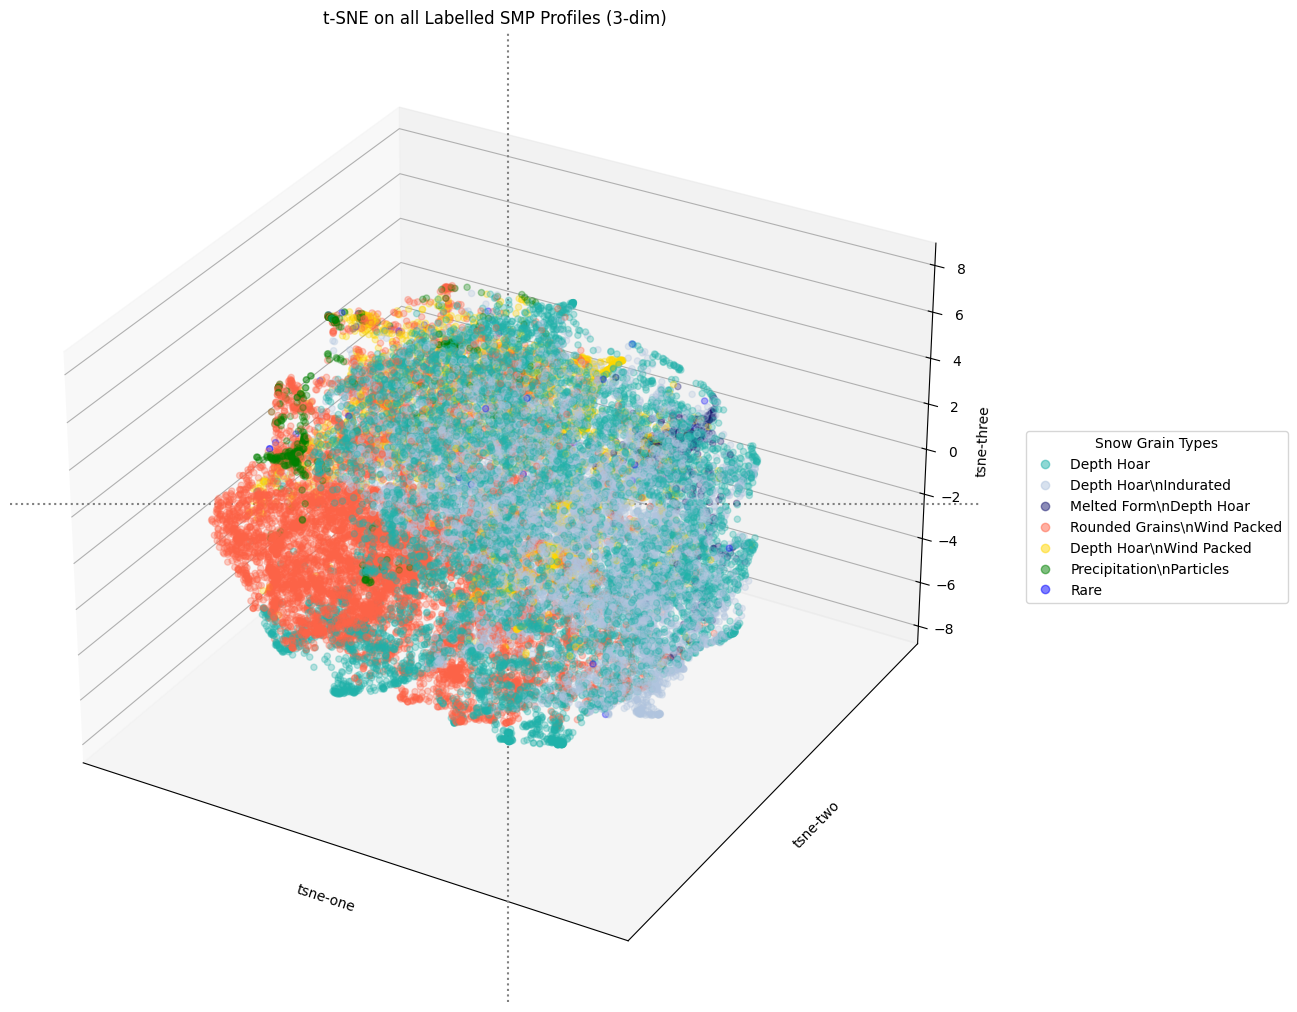

In [60]:
# visualize tsne
visualize_tsne(
    tsne_results = tsne_results,
    colors = colors,
    anti_colors = anti_colors,
)

In [225]:
# retrieve cluster distances
centroids = get_centroids(tsne_results)
print("Centroids:")
print(centroids)

distances = get_distances(centroids, metric=metric, label_order=label_order)
print("\nDistances")
print("   dh     dhid   mfdh   rgwp   dhwp   pp     rare")
print(np.round(distances, 3))

normalized_distances = get_normalized_distances(
    tsne_results, 
    distances, 
    metric=metric,
    max_dist=None,
    )
print("\nNormalized Distances")
print("  dh    dhid  mfdh  rgwp  dhwp  pp    rare")
print(np.round(normalized_distances, 3))

similarity_matrix = get_similarities(normalized_distances)
print("\nSimilarity")
print(np.round(similarity_matrix, 3))


Centroids:
        t-SNE 1   t-SNE 2   t-SNE 3
label                              
3.0    1.754183 -1.161780  1.111475
4.0    2.602997 -0.713217  1.071792
5.0    2.994063  5.224212  0.059512
6.0   -2.753906 -0.105368 -1.895218
12.0  -1.255508  3.253328  0.356015
16.0  -4.493917 -0.928732  3.446989
17.0  -2.251451  1.860202  2.666768

Distances
   dh     dhid   mfdh   rgwp   dhwp   pp     rare
[[ 0.     0.961  6.59   5.521  5.396  6.674  5.253]
 [ 0.961  0.     6.036  6.154  5.58   7.487  5.721]
 [ 6.59   6.036  0.     8.079  4.694 10.267  6.755]
 [ 5.521  6.154  8.079  0.     4.312  5.678  4.993]
 [ 5.396  5.58   4.694  4.312  0.     6.126  2.876]
 [ 6.674  7.487 10.267  5.678  6.126  0.     3.663]
 [ 5.253  5.721  6.755  4.993  2.876  3.663  0.   ]]
Maximum recorded distance between two data points: 17.456494115062846

Normalized Distances
  dh    dhid  mfdh  rgwp  dhwp  pp    rare
[[0.    0.055 0.377 0.316 0.309 0.382 0.301]
 [0.055 0.    0.346 0.353 0.32  0.429 0.328]
 [0.377 0.346 

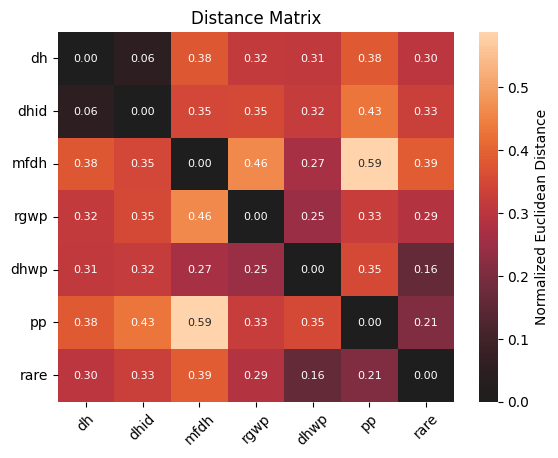

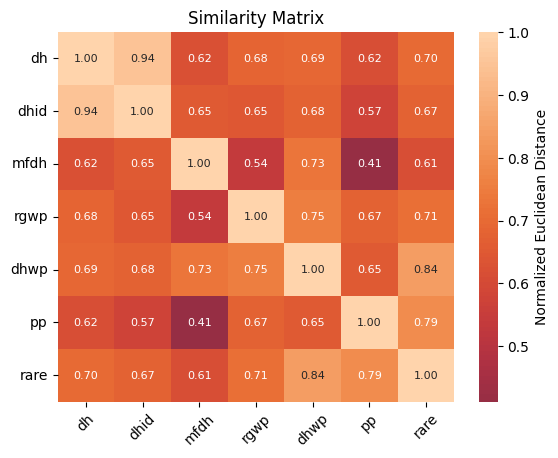

In [230]:
# plot distance matrix
plot_matrix(
    normalized_distances,
    label_order = label_order,
    file_name = None,
    )

plot_matrix(
    similarity_matrix,
    label_order = label_order,
    file_name = None,
    title="Similarity Matrix",
    )

In [112]:
# visualize tsne with cluster distances painted in (for one grain type)

## Run t-SNE: Run n times

In [ ]:
# run n times

all_clustered_data = []

for random_state in random_tokens:
    clustered_data = run_tsne(
        data = data,
        n_components = n_components, 
        verbose = verbose,
        perplexity = perplexity,  
        n_iter = n_iter,
        random_state = random_state,
    )
    all_clustered_data.append(clustered_data)

## Average Cluster Distance Matrix